In [ ]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from datetime import datetime
from scipy.interpolate import griddata
from scipy.optimize import brentq
from scipy import stats



%run Heston_functions_1.ipynb
%run Model Calibration.ipynb


In [3]:
# Below we collect some recent data for option of the asset 'NFLX' (Netflix), which contains strike prices, expiration dates, 
# the last price and etc. From these data, we may use certin regressive machine learning algorithm to "fit" the option data into the
# Heston model (more precisely, we use current data to calibrate the parameters in the Heston model), which is a robust stochastic financial 
# model that captures the variation stock prices. 

In [ ]:
ticker_str = 'NFLX'  # This is the ticker for the underlying we choose, which is Netflix (NFLX) in our case.
r = 0.043          # This is the current discount rate.

parameters = Heston_calibration('NFLX',r)    # Calibrating the parameters for the Heston model of Netflix's stock. 

C:\TEMP\ipykernel_10812\3400981862.py:107: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_str, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed
C:\TEMP\ipykernel_10812\3400981862.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda ph: integrand(ph, 1), eps, phi_max, limit=200)[0]
C:\TEMP\ipykernel_10812\3400981862.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(lambda ph: integrand(ph, 2), eps, phi_max, limit=200)[0]
C:\TEMP\ipykernel_10812\3400981862.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested toler

In [ ]:
[kappa, theta, xi, rho, v0] = parameters
names = ['kappa', 'theta', 'xi', 'rho', 'v0']
for i in range(len(parameters)):
    print(f'The value of {names[i]} of {ticker_str} under the Heston model is {parameters[i]}.')    #printing the calibrated Heston parameters.

The value of kappa of NFLX under the Heston model is 1.4002925511605058.
The value of theta of NFLX under the Heston model is 0.12798822317658942.
The value of xi of NFLX under the Heston model is 0.35789579409367195.
The value of rho of NFLX under the Heston model is -0.4762700520806201.
The value of v0 of NFLX under the Heston model is 0.11988403270453289.


In [ ]:
n_sims = 2000  # This is the number of times of our Monte-Carlo simulation for the hedged payoff.

S0 = 1200        # The spot, strike and expiration time of the option we would like to hedge.
K = 900
T = 1

dt = 1/252

# Here we simulate the final payoff of the unhedged option for [n_sims] many times.
unhedged_profits = np.zeros(n_sims)
S_path,_ = Heston_path_vectorized(S0, T, r, kappa, theta, xi, rho, v0, dt, n_sims)
for k in range (n_sims): 
    unhedged_profits[k] = np.exp(-r*T)*np.maximum(S_path[k,-1] - K,0)


In [7]:
K_1 = 1150     # The second option C_1 with NFLX stock as the underlying (to be used in the Vega hedging simulation).
T_1 = 1.1

K_2 = 800      # The third option C_3 with NFLX stock as the underlying (to be used in the Vega and Delta-Vega hedging simulation).
T_2 = 1.4

n_hedges = 20    # We set 20 equally distributed hedge points in the time interval from now to expiration T = 1 year from now.

# Heston Delta hedging profit simulation:
delta_hedged_profits = delta_hedged_portfolio_profits_vectorized(S0, K, T, r, kappa, theta, xi, rho, v0, dt, n_sims, n_hedges)

# Heston Vega hedging profit simulation:
vega_hedged_profits = vega_hedged_portfolio_profits_vectorized(S0, K, K_1, T, T_1, r, kappa, theta, xi, rho, v0, dt, n_sims, n_hedges)

# Heston Delta-Vega hedging profit simulation:
delta_vega_hedged_profits = delta_vega_hedged_portfolio_profits_vectorized(S0, K, K_1, K_2, T, T_1, T_2, r, kappa, theta, xi, rho, v0, dt, n_sims, n_hedges)


C:\TEMP\ipykernel_10812\3400981862.py:316: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz(integrand(phi, 1), phi, axis=0)  # (n_sims,)
C:\TEMP\ipykernel_10812\3400981862.py:317: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(integrand(phi, 2), phi, axis=0)  # (n_sims,)
C:\TEMP\ipykernel_10812\3400981862.py:319: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J1 = np.trapz(integrand_1(phi, 1), phi, axis=0)  # (n_sims,)
C:\TEMP\ipykernel_10812\3400981862.py:320: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J2 = np.trapz(integrand_1(phi, 2), phi, axis=0)  # (n_sims,)
C:\TEMP\ipykernel_10812\3400981862.p


=== Portfolio 1: Delta Hedged Portfolio ===


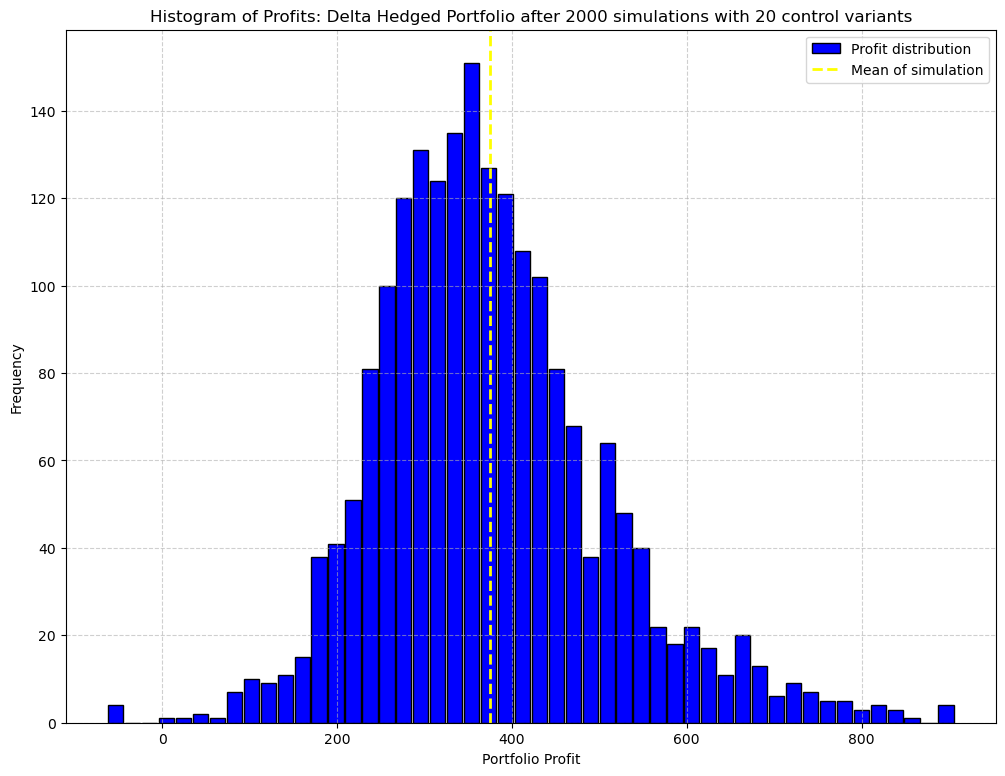

  Mean: 375.1286
  Std: 131.7684
  Min: -62.6235
  Max: 906.1954
  Skewness: 0.6807
  Kurtosis: 1.1644

=== Portfolio 2: Vega Hedged Portfolio ===


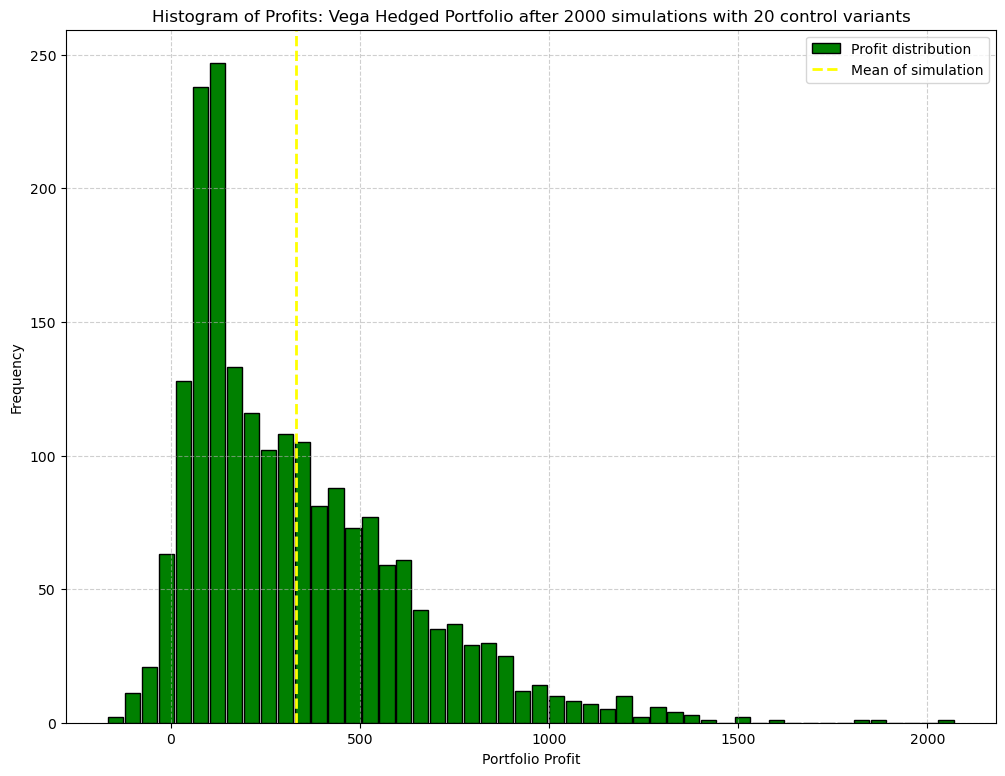

  Mean: 330.3073
  Std: 291.4480
  Min: -167.6638
  Max: 2071.3881
  Skewness: 1.3006
  Kurtosis: 2.1553

=== Portfolio 3: Delta-Vega Hedged Portfolio ===


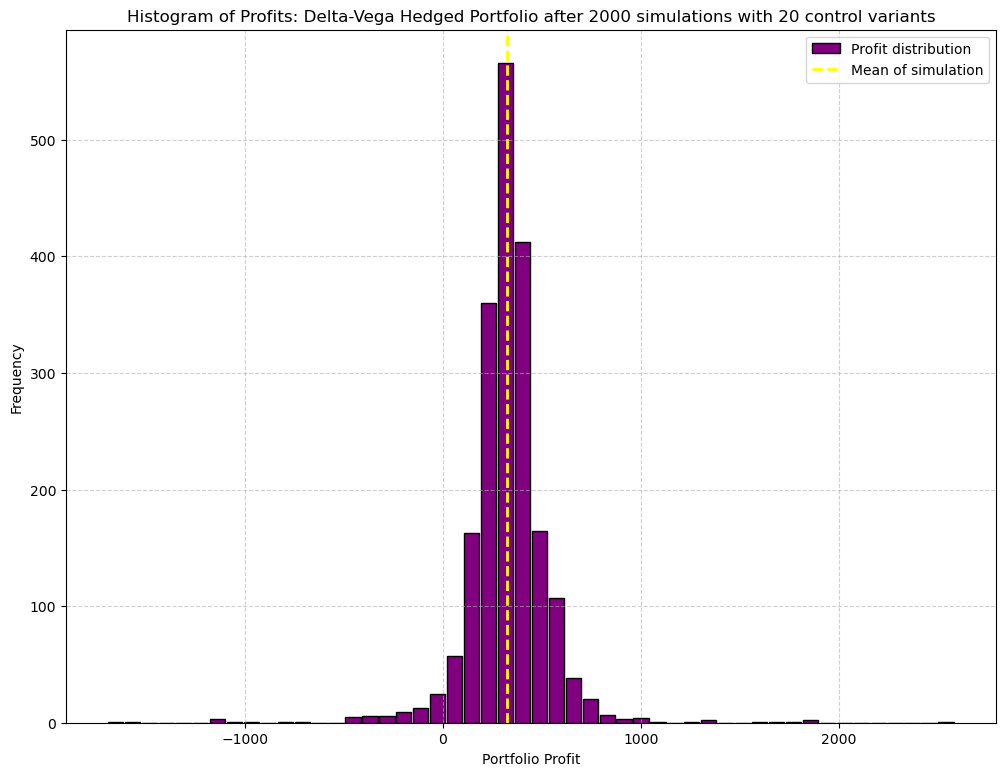

  Mean: 325.6435
  Std: 215.0411
  Min: -1693.5924
  Max: 2581.6643
  Skewness: -0.2564
  Kurtosis: 23.2159

=== Portfolio 4: Unhedged Portfolio ===


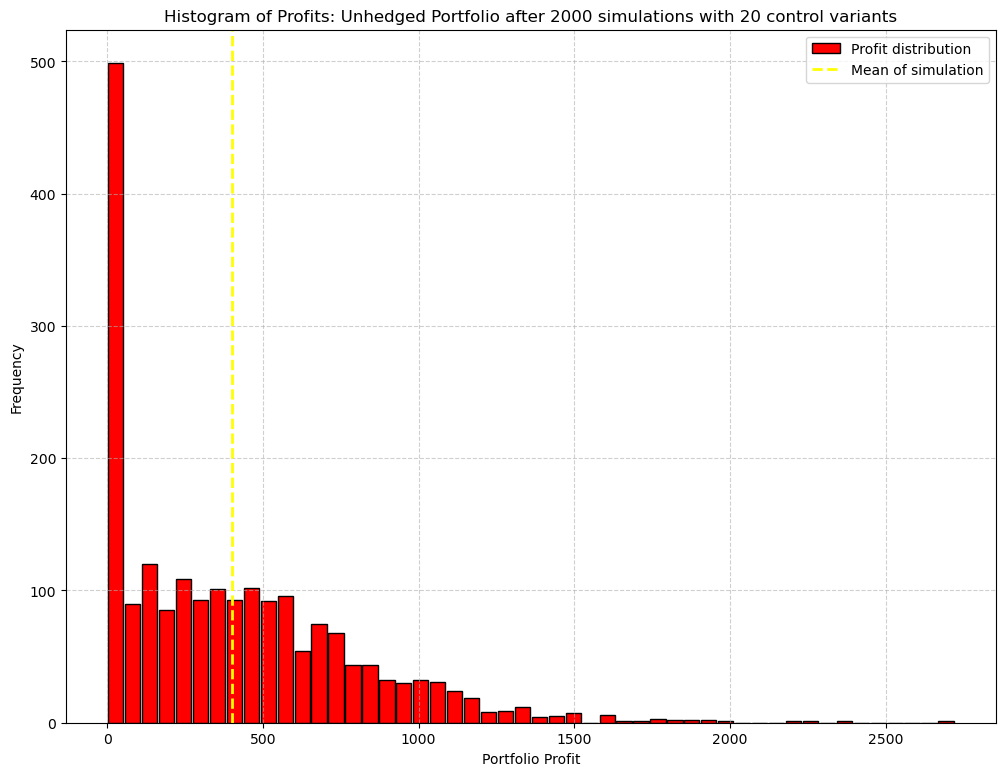

  Mean: 399.9440
  Std: 383.9677
  Min: 0.0000
  Max: 2721.1064
  Skewness: 1.1914
  Kurtosis: 1.9356


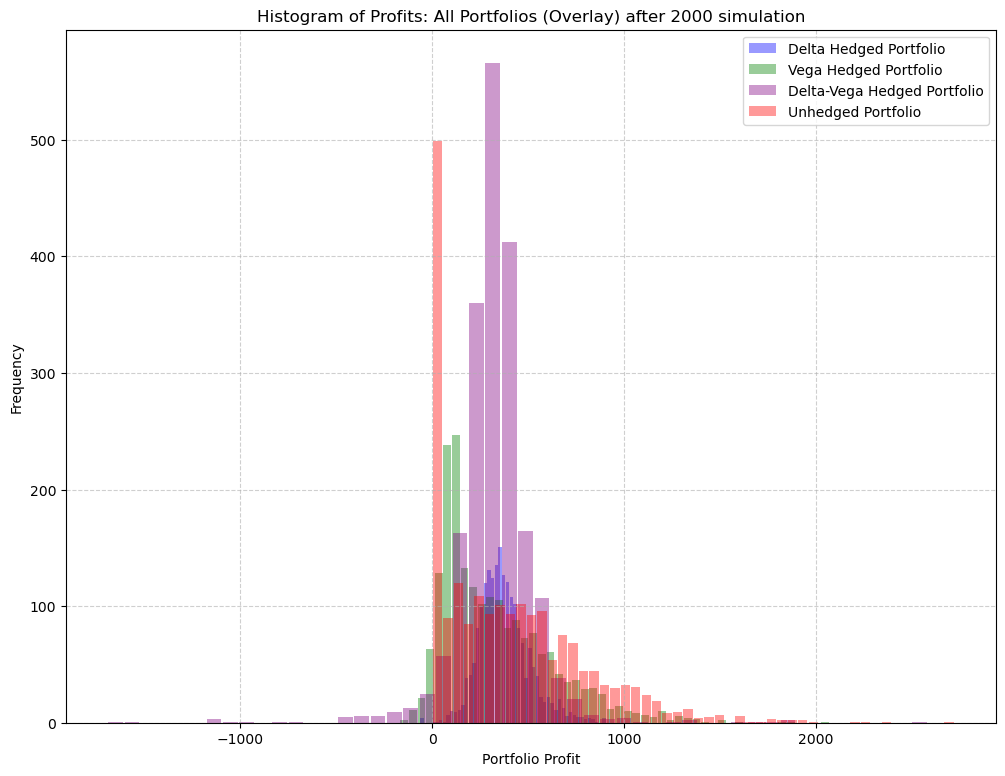

In [ ]:
# Visualizing the histograms of profits under 2000 simulations.
threshold =  np.max(unhedged_profits)  # Reasonably we discard outliers by setting a threshold, 
                                       #which is taken to be the maximum value of the simulated unhedged profits (which are non-negative).
# Truncated simulation data. 
d_cleaned_profits  = delta_hedged_profits[(delta_hedged_profits >= -threshold) & (delta_hedged_profits <= threshold)]           
v_cleaned_profits  = vega_hedged_profits[(vega_hedged_profits >= -threshold) & (vega_hedged_profits <= threshold)]        
dv_cleaned_profits = delta_vega_hedged_profits[(delta_vega_hedged_profits >= -threshold) & (delta_vega_hedged_profits <= threshold)]
u_cleaned_profits  = unhedged_profits[(unhedged_profits >= -threshold) & (unhedged_profits <= threshold)]

# the function that returns useful statstical information on the above data.
def statistics(arr):
    print(f"  Mean: {np.mean(arr):.4f}")
    print(f"  Std: {np.std(arr):.4f}")
    print(f"  Min: {np.min(arr):.4f}")
    print(f"  Max: {np.max(arr):.4f}")
    print(f"  Skewness: {stats.skew(arr):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(arr):.4f}")


profits_list = [
    (d_cleaned_profits, "Delta Hedged Portfolio", "blue"),
    (v_cleaned_profits, "Vega Hedged Portfolio", "green"),
    (dv_cleaned_profits, "Delta-Vega Hedged Portfolio", "purple"),
    (u_cleaned_profits, "Unhedged Portfolio", "red"),
]


for i, (profits, label, color) in enumerate(profits_list, start=1):
    print(f"\n=== Portfolio {i}: {label} ===")
    
    plt.figure(figsize=(12,9))
    plt.hist(profits, bins=50, color=color, edgecolor="black", rwidth=0.9, label = 'Profit distribution')
    plt.xlabel("Portfolio Profit")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Profits: {label} after {n_sims} simulations with {n_hedges} control variants")
    plt.axvline(np.mean(profits), color='yellow', linestyle='--', linewidth=2, label='Mean of simulation')
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()
    
    # Call statistics for each profits set
    statistics(profits)
    

# Combined histogram 
plt.figure(figsize=(12,9))
for profits, label, color in profits_list:
    plt.hist(profits, bins=50, color=color, alpha=0.4, label=label, rwidth=0.9)  # alpha makes it lighter
plt.xlabel("Portfolio Profit")
plt.ylabel("Frequency")
plt.title(f'Histogram of Profits: All Portfolios (Overlay) after {n_sims} simulation')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()



After a massive number of Monte-Carlo simulation, we see from the above outputs, that all the hedging portfolios have significantly greater probability of achieving (positive) profits that are close to the expectation, comparing to the unhedged payoff of the option (which is highly likely to be zero).

To compare among the three hedged portfolios, the delta-vega hedged portfolio tends to protect the expected profit mostly effectively as most of its simulated outputs concentrate near the expectation. The delta hedged portfolio is the second most effective one, while vega hedged portfolio, though also protects profits, is the worst, as it is highly right-skewed (hence not considerably better than the unhedged one). 


The standard deviation in Delta Hedged Portfolio is reduced by 65.68%.
The standard deviation in Vega Hedged Portfolio is reduced by 24.10%.
The standard deviation in Delta-Vega Hedged Portfolio is reduced by 44.00%.


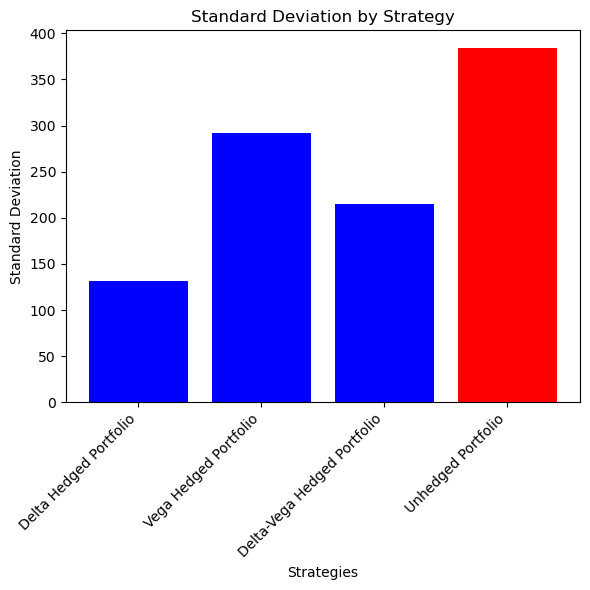

In [26]:
# Hedging Result Evaluation
# The efficiency of the above hedging strategies could be evaluated by the standard deviation of profits, which measures how well are the simulated profits cluster around the expected mean values. 

profits_std = []    

for profits, label, color in profits_list:
    profits_std.append((label, np.std(profits)))

unhedged_std = profits_std[-1][1]

for label, std in profits_std[:-1]:
    print(f'The standard deviation in {label} is reduced by {100*(unhedged_std - std)/unhedged_std:.2f}%.')

# Visualize the reduction in standard deviation.

# Create bar chart
labels = [label for label, std in profits_std]
stds = [std for label, std in profits_std]


# Add labels and title
plt.figure(figsize=(6, 6))
colors = ['blue'] * (len(profits_std) - 1) + ['red']

plt.bar(labels, stds, color = colors)
plt.xlabel("Strategies")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Strategy")



plt.xticks(rotation=45, ha='right')  # ha='right' aligns labels nicely

# Show the plot
plt.tight_layout()  # adjusts layout to prevent clipping
plt.show()  